In [1]:
import sys

sys.path.append('../')

# ZINB-WaVE model

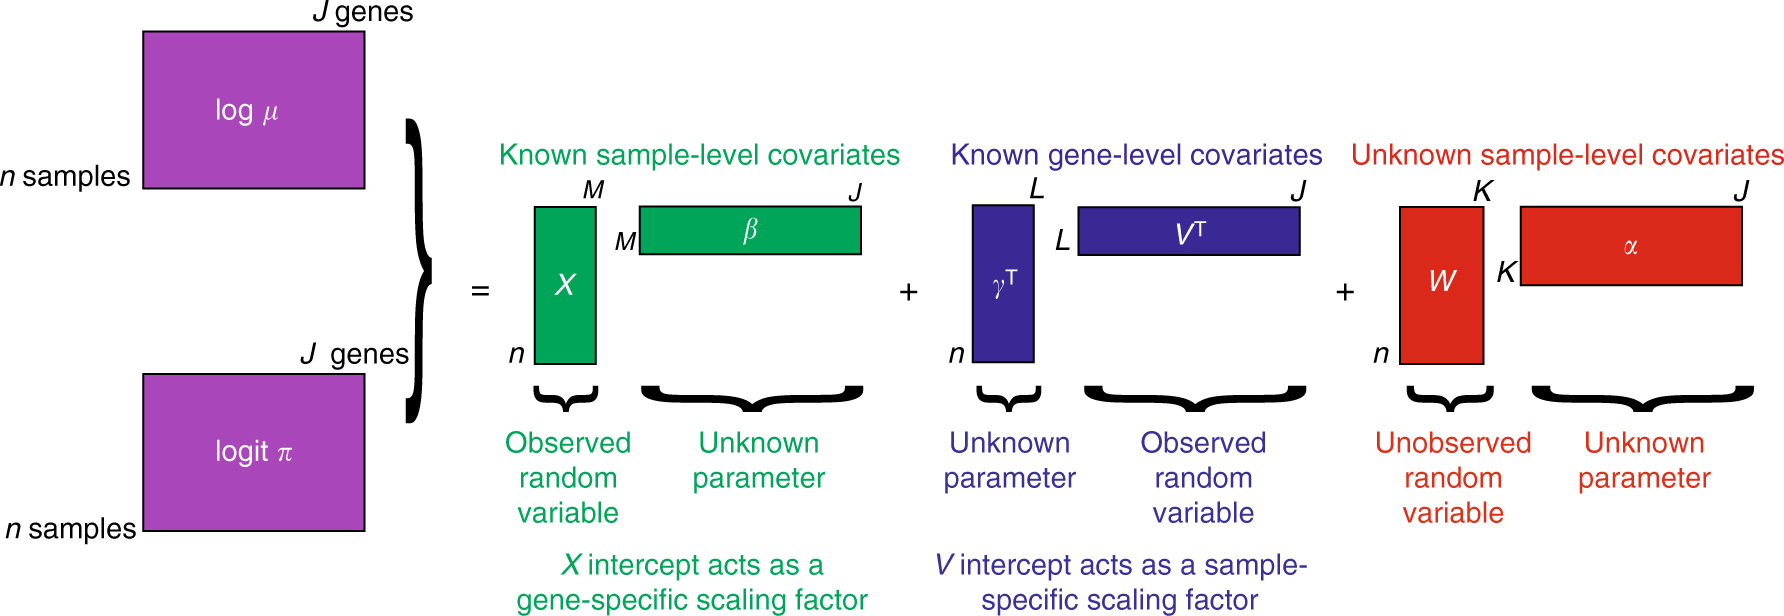

In [3]:
url = 'https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41467-017-02554-5/MediaObjects/41467_2017_2554_Fig1_HTML.png'
from IPython import display
display.Image(url)

In [2]:
import ZINB_grad 
import torch
import numpy as np
import data_prep
import helper
from importlib import reload
from torch.utils.data import DataLoader, random_split
from matplotlib import pyplot as plt
from torch.nn.functional import one_hot

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [53]:
reload(ZINB_grad)

<module 'ZINB_grad' from '/home/longlab/Data/Thesis/Code/Colab_Notebooks/../ZINB_grad.py'>

In [3]:
torch.manual_seed(197)

In [4]:
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Zeisel Data Set

In [12]:
cortex = data_prep.CORTEX()

In [13]:
y, labels = next(iter(DataLoader(cortex, 
                                 batch_size= cortex.n_cells,
                                 shuffle=True)))

Increasing learning rate

With 300 epochs

In [7]:
model = ZINB_grad.ZINB_WaVE(Y = y, K = 10, device =device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.08)
losses, neg_log_liks = ZINB_grad.train_ZINB(y, optimizer, model, epochs = 300)

epoch:   1  loss: 9928494.73
epoch:  51  loss: 3873025.78
epoch: 101  loss: 3625271.43
epoch: 151  loss: 3599656.44
epoch: 201  loss: 3591258.76
epoch: 251  loss: 3586816.07
epoch: 300  loss: 3583850.46


In [14]:
neg_log_liks[-1]

3578835.236313777

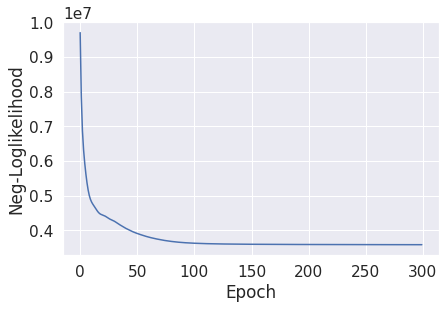

In [15]:
helper.plot_loss(losses)

### With 150 epochs

In [17]:
model = ZINB_grad.ZINB_WaVE(Y = y, K = 10, device =device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.08)
losses, neg_log_liks = ZINB_grad.train_ZINB(y, optimizer, model, epochs = 150)

epoch:   1  loss: 9744406.16
epoch:  51  loss: 3865804.72
epoch: 101  loss: 3628034.87
epoch: 150  loss: 3602771.93


3597095.263200491


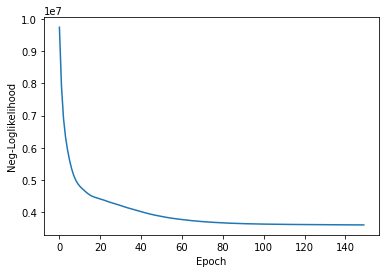

In [18]:
print(neg_log_liks[-1])
helper.plot_loss(losses)

In [7]:
model = ZINB_grad.ZINB_WaVE(Y = y, K = 10)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [8]:
losses, neg_log_liks = ZINB_grad.train_ZINB(y, optimizer, model, epochs = 400)

epoch:   1  loss: 9855616.70
epoch:  51  loss: 5204446.29
epoch: 101  loss: 4508938.36
epoch: 151  loss: 4174809.72
epoch: 201  loss: 3948852.36
epoch: 251  loss: 3827023.52
epoch: 301  loss: 3752248.22
epoch: 351  loss: 3698358.46
epoch: 400  loss: 3661613.39


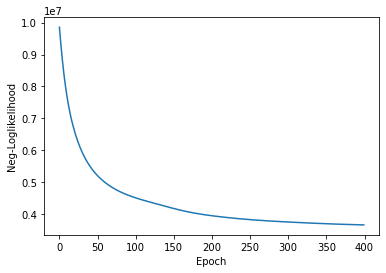

In [9]:
helper.plot_loss(losses)

Now, we will test the W of the ZINB model with 150 epochs and lr= 0.08

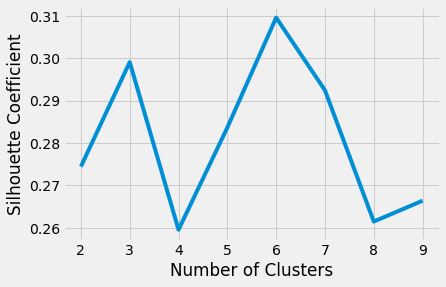

In [25]:
w = model.W.detach().numpy()

sil_coeff = helper.kmeans(w)

helper.plot_si(sil_coeff)

In [20]:
labels = labels.numpy()

In [26]:
helper.measure_q(w, labels, n_clusters=7)

The NMI score is: 0.7655360353111427
The ARI score is: 0.723612167041404
The ASW score is: 0.2924725115299225


## Early stopping

In [14]:
test_size = int(cortex.n_cells *0.2)
train, test = random_split(cortex, [cortex.n_cells-test_size, test_size])

In [15]:
y_train, labels_train = train[:]
y_test, labels_test = test[:]

In [20]:
%%time
model = ZINB_grad.ZINB_WaVE(Y = y_train, K = 10, device = device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.08)
losses, neg_log_liks, val_losses = ZINB_grad.train_ZINB_with_val(y_train,
                                                    y_test, 
                                                    optimizer, 
                                                    model,
                                                    device,
                                                    epochs = 300,
                                                    early_stop = False)

validation loss: 1194466.72
epoch:   1  loss: 7699372.02
validation loss: 1131218.06
epoch:  51  loss: 3107306.51
validation loss:  808755.17
epoch: 101  loss: 2898273.06
validation loss:  809485.23
epoch: 151  loss: 2876507.75
validation loss:  813204.13
epoch: 201  loss: 2870315.41
validation loss:  816642.96
epoch: 251  loss: 2867123.22
validation loss:  820003.10
validation loss:  824131.73
epoch: 300  loss: 2864936.23
CPU times: user 5min 10s, sys: 1min 24s, total: 6min 34s
Wall time: 55 s


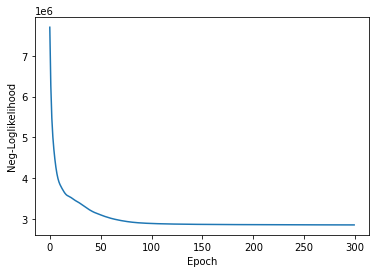

In [21]:
helper.plot_loss(neg_log_liks)

Validation loss:

Text(0.5, 0, 'Epoch')

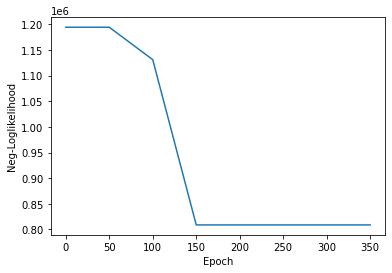

In [22]:
plt.plot(np.arange(len(val_losses))*50, np.array(val_losses))
plt.ylabel('Neg-Loglikelihood')
plt.xlabel('Epoch')

In [23]:
%%time
model = ZINB_grad.ZINB_WaVE(Y = y_train, K = 10, device = device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.08)
losses, neg_log_liks, val_losses = ZINB_grad.train_ZINB_with_val(y_train,
                                                    y_test, 
                                                    optimizer, 
                                                    model,
                                                    device,
                                                    epochs = 300,
                                                    early_stop = True)

validation loss: 1212257.61
epoch:   1  loss: 7736750.46
validation loss: 1143821.48
epoch:  51  loss: 3122061.20
validation loss:  809893.79
epoch: 101  loss: 2909569.19
validation loss:  798468.20
epoch: 151  loss: 2878457.56
validation loss:  807197.91
validation loss:  796645.11
epoch: 151  loss: 2878457.56
CPU times: user 2min 45s, sys: 55.9 s, total: 3min 41s
Wall time: 31.2 s


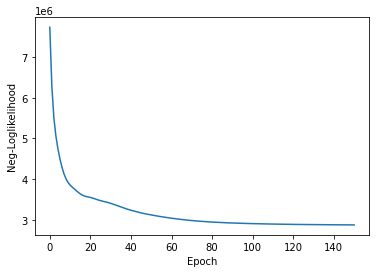

In [24]:
helper.plot_loss(neg_log_liks)

## Imputation

In [8]:
data = y.numpy().copy()

In [9]:
data_c, i, j, ind = helper.corrupting(data)

In [10]:
data_c

array([[ 9.,  0.,  0., ..., 16.,  0.,  1.],
       [ 0., 22., 11., ..., 30., 55.,  0.],
       [ 2., 10.,  1., ...,  7.,  0.,  0.],
       ...,
       [15., 13.,  0., ..., 10.,  0.,  0.],
       [32., 48.,  0., ..., 29.,  0., 16.],
       [ 4.,  0., 10., ..., 10., 20.,  0.]], dtype=float32)

In [11]:
model = ZINB_grad.ZINB_WaVE(Y = torch.from_numpy(data_c), K = 10, device = device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.08)
losses, neg_log_liks = ZINB_grad.train_ZINB(y, optimizer, model, epochs = 150)

epoch:   1  loss: 9928494.73
epoch:  51  loss: 3873025.78
epoch: 101  loss: 3625271.43
epoch: 150  loss: 3599908.85


In [12]:
mu = torch.exp(model.X @ model.beta_mu + model.gamma_mu.T @ model.V.T + \
            model.W @ model.alpha_mu)

In [14]:
helper.Eval_Imputation(data, mu.detach().numpy(), i, j, ind)

2.2420830726623535

Better than the scvi and comparable to the original ZINB-WaVE score! (I'm really excited!!!!!!!!!!)

## Hierarchical clustering

In [23]:
helper.HC(w, labels)

[0.7161113472014917,
 0.6243204402848804,
 0.5808648401658683,
 0.7510574363439041]

# Brain Large Data Set

In [48]:
brain = data_prep.Brain_Large()

In [17]:
brain_data_loader = DataLoader(brain, batch_size= 3000, shuffle=True)

In [18]:
%%time
for batch, index in brain_data_loader:
    break

CPU times: user 5.2 s, sys: 862 ms, total: 6.07 s
Wall time: 33.1 s


In [21]:
brain_data_loader2 = DataLoader(brain, batch_size= 3000, shuffle=False)

In [22]:
%%time
for batch, index in brain_data_loader2:
    break

CPU times: user 3.84 s, sys: 92.2 ms, total: 3.93 s
Wall time: 3.93 s


Let's read a part of the data sequentially for more samples:

In [25]:
%%time
sampler2 = torch.utils.data.DataLoader(brain,
                                       batch_size= batch_size,
                                       sampler = data_prep.Indice_Sampler(torch.arange(100000, 110000)),
                                       shuffle=False)
    
batch, index = next(iter(sampler2))

CPU times: user 3.95 s, sys: 92 ms, total: 4.04 s
Wall time: 4.05 s


The time for not shuffled data is way better => We can read the data sequentially and then shuffle it? Let's do it!

To avoid overfitting, the shuffling process is done in two stages: 
1. The intervals are shuffled 
2. After reading the data corresponding to the specific interval, the batch is shuffled too.

In [32]:
batch_size = 10125
intervals = np.arange(0, brain.n_cells-1, batch_size)
intervals = np.array([[intervals[i], intervals[i+1]] for i in range(len(intervals)-1)])
np.random.shuffle(intervals) # First data shuffling (intervals are shuffled)
print(intervals[1:10])

[[982125 992250]
 [840375 850500]
 [972000 982125]
 [668250 678375]
 [465750 475875]
 [374625 384750]
 [496125 506250]
 [313875 324000]
 [253125 263250]]


 The best way to implement the sequential read is through the pytorch's Iterable dataset (https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset). However, due to the time limit, I will implement it in the following way:

In [64]:
batch[p].shape

torch.Size([10125, 720])

In [67]:
%%time
PATH = '/home/longlab/Data/Thesis/Data/'
perms = []
K = 10
size = (batch_size, brain.n_select_genes)


# a random initialziation
model = ZINB_grad.ZINB_WaVE(Y = torch.randint(0,100, size = size), 
                            K = K)

# First phase of the training
for i, interval in enumerate(intervals):

    sampler = torch.utils.data.DataLoader(brain,
                                          batch_size= batch_size,
                                          sampler = data_prep.Indice_Sampler(torch.arange(interval[0], interval[1])),
                                          shuffle=False)

    batch, _ = next(iter(sampler))
    batch = batch.reshape(batch_size, brain.n_select_genes) 
    
    # Second data shuffling (the data in the batch is shuffled)
    perm = torch.randperm(batch_size)
    batch = batch[perm]
    
    print("Training the Model")
    
    # Rest of the code for training ... 
    # Please see the X to understand how to perform the scalability and neg-likelihood tests 

Training the Model
epoch:   1  loss: 39298324.00
epoch:  51  loss: 17183128.00
epoch: 101  loss: 14548575.00
epoch: 151  loss: 13540769.00
epoch: 201  loss: 13070050.00
epoch: 251  loss: 12760912.00
epoch: 300  loss: 12456463.00
Training the Model
epoch:   1  loss: 20023928.00
epoch:  51  loss: 12699043.00
epoch: 101  loss: 12249971.00
epoch: 151  loss: 12043696.00
epoch: 201  loss: 11896927.00
epoch: 251  loss: 11784829.00
epoch: 300  loss: 11706098.00
Training the Model
epoch:   1  loss: 17510960.00
epoch:  51  loss: 12667984.00
epoch: 101  loss: 12324848.00
epoch: 151  loss: 12184438.00
epoch: 201  loss: 12101134.00
epoch: 251  loss: 12046294.00
epoch: 300  loss: 12009301.00
Training the Model
epoch:   1  loss: 18517540.00
epoch:  51  loss: 12494983.00
epoch: 101  loss: 12165338.00
epoch: 151  loss: 12036675.00
epoch: 201  loss: 11967942.00
epoch: 251  loss: 11924669.00
epoch: 300  loss: 11894795.00
Training the Model
epoch:   1  loss: 18779778.00
epoch:  51  loss: 12507761.00
epoch

The following code will use the Pytorch's `DataLoader` to perform the permutations and shuffling. As this method will read data randomly (instead of sequentially), its wall time is way higher than the previous implementation.

In [13]:
batch_size = 3000
brain_data_loader = DataLoader(brain, batch_size= batch_size, shuffle=True)

In [14]:
PATH = '/home/longlab/Data/Thesis/Data/'
indices = []
K = 10
size = (batch_size, brain.n_select_genes)

# a random initialziation
model = ZINB_grad.ZINB_WaVE(Y = torch.randint(0,100, size = size), 
                            K = K)

print("Reading Data")
for i, data in enumerate(brain_data_loader):
    
    batch = data[0].reshape(batch_size, brain.n_select_genes) 
    index = data[1]
    
    print("Training the Model")
    
    # Same as the previous cell

Reading Data
Training the Model
epoch:   1  loss: 11775237.00
epoch:  51  loss: 5139065.00
epoch: 101  loss: 4351527.00
epoch: 151  loss: 4055487.25
epoch: 201  loss: 3918952.25
epoch: 251  loss: 3829117.00
epoch: 300  loss: 3737465.00
Reading Data
Training the Model
epoch:   1  loss: 5845359.50
epoch:  51  loss: 3831552.75
epoch: 101  loss: 3698323.25
epoch: 151  loss: 3630920.25
epoch: 201  loss: 3586902.25
epoch: 251  loss: 3554214.75
epoch: 300  loss: 3529718.75
Reading Data
Training the Model
epoch:   1  loss: 5209620.00
epoch:  51  loss: 3681560.50
epoch: 101  loss: 3577785.50
epoch: 151  loss: 3537366.25
epoch: 201  loss: 3514059.25
epoch: 251  loss: 3499309.50
epoch: 300  loss: 3488596.25
Reading Data
Training the Model
epoch:   1  loss: 5411867.00
epoch:  51  loss: 3670706.75
epoch: 101  loss: 3571422.50
epoch: 151  loss: 3535080.50
epoch: 201  loss: 3514321.00
epoch: 251  loss: 3500460.75
epoch: 300  loss: 3491008.75
Reading Data
Training the Model
epoch:   1  loss: 5693279.0

# RETINA Dataset

## Batch Effect correction

In [5]:
retina = data_prep.RETINA()

In [6]:
j = retina.n_cells

In [7]:
test_size = 3829
train, test = random_split(retina, [j-test_size, test_size])
y_val, _ = test[:]
y_val = y_val.to(device)

In [8]:
batch_size= 4000
retina_dl = DataLoader(train, batch_size= batch_size, shuffle=False, drop_last= False)

First, we will see the results without including batch information in the model.

In [12]:
PATH = '/home/longlab/Data/Thesis/Data/'
indices = []
K = 10
size = (batch_size, retina.n_genes)

model = ZINB_grad.ZINB_WaVE(Y = torch.randint(0,100, size = size).to(device), 
                            K = K, device = device)

n_epochs = np.min([round((10**4/j)*300),150])

for i, data in enumerate(retina_dl):

    batch = data[0].to(device)
#     index = data[1]
#     indices.append(index)

    # Using the alphas, betas, and theta from the previous model.
    model = ZINB_grad.ZINB_WaVE(Y = batch, K = K, device= device,
                                alpha_mu = model.alpha_mu,
                                alpha_pi = model.alpha_pi,
                                beta_mu = model.beta_mu,
                                beta_pi =  model.beta_pi, 
                               log_theta = model.log_theta)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.08)

    losses, neg_log_liks, val_losses = ZINB_grad.train_ZINB_with_val(batch, 
                                                         y_val, 
                                                         optimizer, 
                                                         model,
                                                         device,
                                                         epochs = n_epochs,
                                                         PATH = PATH)
    #load the best model in the training process
    model.load_state_dict(torch.load(PATH + 'best_trained_model.pt'))

    # save the W and gammas of the trained model
    W_gammas = {key: model.state_dict()[key] for key in ['gamma_mu', 'gamma_pi', 'W']}
    torch.save(W_gammas, PATH + f"W_gammas_RETINA_nbc_iter_{i}.pt")
    torch.save(torch.tensor(losses),PATH +\
               f"phase_1_losses_RETINA_nbc_iter_{i}.pt")
    torch.save(torch.tensor(val_losses),PATH + \
               f"phase_1_val_losses_RETINA_nbc_iter_{i}.pt")

#save the best global alpha, beta and theta
alpha_beta_theta = {key: model.state_dict()[key] for key in ['log_theta', 
                                                             'beta_mu', 
                                                             'beta_pi', 
                                                             'alpha_mu', 
                                                             'alpha_pi']}
torch.save(alpha_beta_theta, PATH + f"alpha_beta_theta_best_global_RETINA_nbc.pt")

validation loss: 16675466.00
epoch:   1  loss: 30643770.00
validation loss: 16035011.00
epoch:  51  loss: 12278188.00
validation loss: 12606562.00
epoch: 101  loss: 12006475.00
validation loss: 12420937.00
validation loss: 12385910.00
epoch: 150  loss: 11936070.00
validation loss: 12395545.00
epoch:   1  loss: 20560666.00
validation loss: 12161767.00
epoch:  51  loss: 11845392.00
validation loss: 11850786.00
epoch: 101  loss: 11761816.00
validation loss: 11865823.00
validation loss: 11908366.00
epoch: 150  loss: 11746563.00
validation loss: 11856834.00
epoch:   1  loss: 16082156.00
validation loss: 11743998.00
epoch:  51  loss: 11923459.00
validation loss: 11616931.00
epoch: 101  loss: 11871431.00
validation loss: 11648852.00
validation loss: 11705562.00
epoch: 150  loss: 11878452.00
validation loss: 11613822.00
epoch:   1  loss: 13899859.00
validation loss: 11637362.00
epoch:  51  loss: 11783487.00
validation loss: 11603017.00
epoch: 101  loss: 11779613.00
validation loss: 11695231.00

In [15]:
n_epochs = 40
for i, data in enumerate(retina_dl):

    batch = data[0].to(device)
    # Reading the W and Gammas
    W_gammas = torch.load(PATH + f"W_gammas_RETINA_nbc_iter_{i}.pt")

    # Using alphas, betas, and theta from the trained model and freezing them
    model2 = ZINB_grad.ZINB_WaVE(Y = batch, K = K, device = device, 
                                 W = torch.nn.Parameter(W_gammas['W']),
                                 gamma_mu = torch.nn.Parameter(W_gammas['gamma_mu']),
                                 gamma_pi = torch.nn.Parameter(W_gammas['gamma_pi']),
                                alpha_mu = model.alpha_mu.detach(),
                                alpha_pi = model.alpha_pi.detach(),
                                beta_mu = model.beta_mu.detach(),
                                beta_pi =  model.beta_pi.detach(), 
                               log_theta = model.log_theta.detach())
    model2.to(device)
    optimizer = torch.optim.Adam(model2.parameters(), lr = 0.08)
    losses, neg_log_liks, val_losses = ZINB_grad.train_ZINB_with_val(batch, 
                                                         y_val, 
                                                         optimizer, 
                                                         model2,
                                                         device,
                                                         epochs = n_epochs,
                                                         PATH = PATH )
    #load the best model in the training process
    model2.load_state_dict(torch.load(PATH + 'best_trained_model.pt'))
    # save the W and gammas of the re-trained model
    W_gammas = {key: model2.state_dict()[key] for key in ['gamma_mu',
                                                          'gamma_pi',
                                                          'W']}
    torch.save(W_gammas,PATH + \
               f"W_gammas_RETINA_nbc_iter_{i}.pt")
    torch.save(torch.tensor(losses),PATH +\
               f"phase_2_losses_RETINA_nbc_iter_{i}.pt")
    torch.save(torch.tensor(val_losses),PATH +\
               f"phase_2_val_losses_RETINA_nbc_iter_{i}.pt")
    

validation loss: 11604260.00
epoch:   1  loss: 12704671.00
validation loss: 11603300.00
validation loss: 11603820.00
epoch:  40  loss: 11997937.00
validation loss: 11602752.00
epoch:   1  loss: 12143141.00
validation loss: 11601665.00
validation loss: 11602836.00
epoch:  40  loss: 11934795.00
validation loss: 11604045.00
epoch:   1  loss: 12157999.00
validation loss: 11603931.00
validation loss: 11602654.00
epoch:  40  loss: 12065081.00
validation loss: 11605506.00
epoch:   1  loss: 11782211.00
validation loss: 11603729.00
validation loss: 11602539.00
epoch:  40  loss: 11780152.00


In [20]:
W = torch.cat([torch.load(PATH + f"W_gammas_RETINA_nbc_iter_{i}.pt")['W'] for i in range(4)], 0)

In [22]:
W.shape

torch.Size([16000, 10])

In [27]:
indices = train[:][1]

In [24]:
helper.entropy_batch_mixing(W.numpy(), retina.batchID[indices])

0.20082524993699125

/home/longlab/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/longlab/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


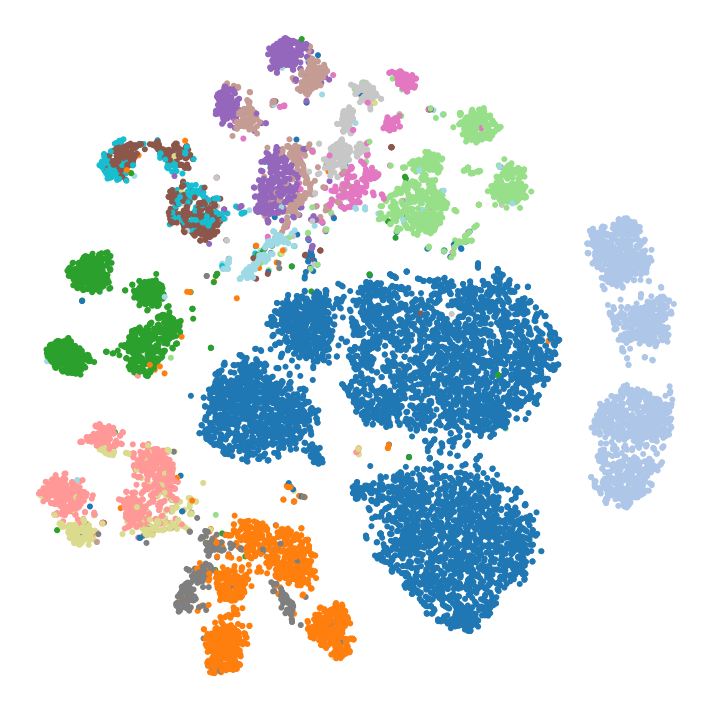

In [28]:
latent = helper.plot_tSNE(W.numpy(),
                          retina.cluster[indices], 
                         cmap=plt.get_cmap("tab20", 15))

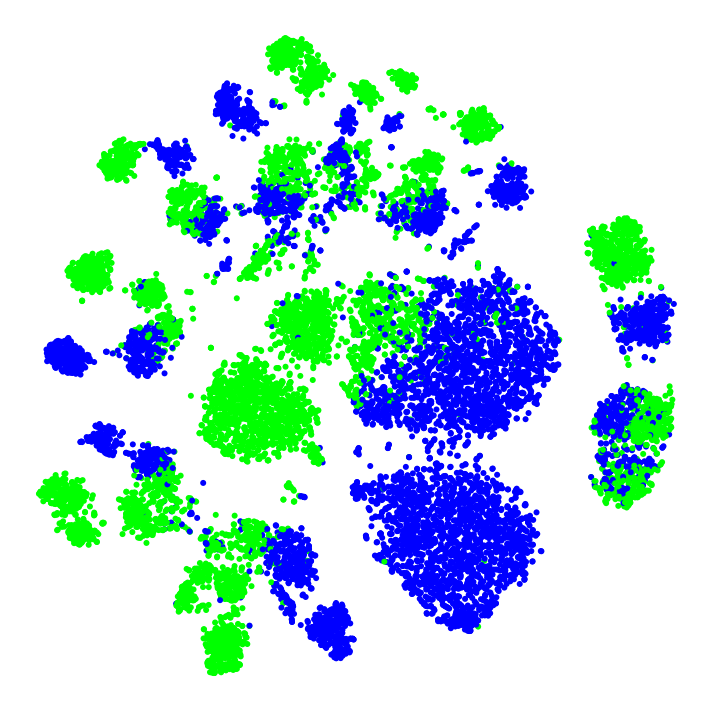

In [29]:
_ =  helper.plot_tSNE(latent, 
                      retina.batchID[indices],
                      cmap=plt.get_cmap("brg", 2), 
                      perform_tsne=False)

Now, we will see the results of batch information included.

In [9]:
PATH = '/home/longlab/Data/Thesis/Data/'
indices = []
K = 10
groups = 2
size = (batch_size, retina.n_genes)
X = torch.ones((batch_size, 3))
X_val = torch.ones((test_size, 3))

# X_val[:,1] = torch.tensor(retina.batchID[test[:][1]])

X_val[:,1:] = one_hot(torch.tensor(retina.batchID[test[:][1]]).long(),
                     num_classes = groups).reshape((-1,groups))

model = ZINB_grad.ZINB_WaVE(Y = torch.randint(0,100, size = size).to(device), X=X,
                            K = K, device = device)

n_epochs = np.min([round((10**4/j)*300),150])

for i, data in enumerate(retina_dl):

    batch = data[0].to(device)
    index = data[1]
    # Considering batch information in the model
#     X[:,1] = torch.tensor(retina.batchID[index])

    X[:,1:] = one_hot(torch.tensor(retina.batchID[index]).long(),
                      num_classes = groups).reshape((-1,groups))
    
    # Using the alphas, betas, and theta from the previous model.
    model = ZINB_grad.ZINB_WaVE(Y = batch, K = K, device= device, X=X,
                                alpha_mu = model.alpha_mu,
                                alpha_pi = model.alpha_pi,
                                beta_mu = model.beta_mu,
                                beta_pi =  model.beta_pi, 
                               log_theta = model.log_theta)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.08)

    losses, neg_log_liks, val_losses = ZINB_grad.train_ZINB_with_val(batch, 
                                                                     y_val, 
                                                                     optimizer, 
                                                                     model,
                                                                     device,
                                                                     X_val = X_val,
                                                                     epochs = n_epochs,
                                                                     PATH = PATH)
    #load the best model in the training process
    model.load_state_dict(torch.load(PATH + 'best_trained_model.pt'))

    # save the W and gammas of the trained model
    W_gammas = {key: model.state_dict()[key] for key in ['gamma_mu', 'gamma_pi', 'W']}
    torch.save(W_gammas, PATH + f"W_gammas_RETINA_bc_iter_{i}.pt")
    torch.save(torch.tensor(losses),PATH +\
               f"phase_1_losses_RETINA_bc_iter_{i}.pt")
    torch.save(torch.tensor(val_losses),PATH + \
               f"phase_1_val_losses_RETINA_bc_iter_{i}.pt")

#save the best global alpha, beta and theta
alpha_beta_theta = {key: model.state_dict()[key] for key in ['log_theta', 
                                                             'beta_mu', 
                                                             'beta_pi', 
                                                             'alpha_mu', 
                                                             'alpha_pi']}
torch.save(alpha_beta_theta, PATH + f"alpha_beta_theta_best_global_RETINA_bc.pt")

validation loss: 17022458.00
epoch:   1  loss: 34307048.00
validation loss: 16362712.00
epoch:  51  loss: 12231558.00
validation loss: 12895343.00
epoch: 101  loss: 11952953.00
validation loss: 12764797.00
validation loss: 12724995.00
epoch: 150  loss: 11880204.00
validation loss: 12727825.00
epoch:   1  loss: 22714814.00
validation loss: 12432884.00
epoch:  51  loss: 11812233.00
validation loss: 11772658.00
epoch: 101  loss: 11734698.00
validation loss: 11768586.00
validation loss: 11824295.00
epoch: 150  loss: 11726506.00
validation loss: 11773535.00
epoch:   1  loss: 16272810.00
validation loss: 11672112.00
epoch:  51  loss: 11878821.00
validation loss: 11660585.00
epoch: 101  loss: 11849877.00
validation loss: 11719704.00
validation loss: 11792464.00
epoch: 150  loss: 11869091.00
validation loss: 11661168.00
epoch:   1  loss: 14211483.00
validation loss: 11648369.00
epoch:  51  loss: 11759899.00
validation loss: 11643540.00
epoch: 101  loss: 11763969.00
validation loss: 11742272.00

In [10]:
n_epochs = 100
for i, data in enumerate(retina_dl):

    batch = data[0].to(device)
    index = data[1]
    
    # Considering batch information in the model
#     X[:,1] = torch.tensor(retina.batchID[index])
    X[:,1:] = one_hot(torch.tensor(retina.batchID[index]).long(),
                      num_classes = groups).reshape((-1,groups))
    
    # Reading the W and Gammas
    W_gammas = torch.load(PATH + f"W_gammas_RETINA_bc_iter_{i}.pt")

    # Using alphas, betas, and theta from the trained model and freezing them
    model2 = ZINB_grad.ZINB_WaVE(Y = batch, K = K, device = device, X=X,
                                 W = torch.nn.Parameter(W_gammas['W']),
                                 gamma_mu = torch.nn.Parameter(W_gammas['gamma_mu']),
                                 gamma_pi = torch.nn.Parameter(W_gammas['gamma_pi']),
                                alpha_mu = model.alpha_mu.detach(),
                                alpha_pi = model.alpha_pi.detach(),
                                beta_mu = model.beta_mu.detach(),
                                beta_pi =  model.beta_pi.detach(), 
                               log_theta = model.log_theta.detach())
    model2.to(device)
    optimizer = torch.optim.Adam(model2.parameters(), lr = 0.08)
    losses, neg_log_liks, val_losses = ZINB_grad.train_ZINB_with_val(batch, 
                                                         y_val, 
                                                         optimizer, 
                                                         model2,
                                                         device,
                                                         X_val = X_val,
                                                         epochs = n_epochs,
                                                         PATH = PATH )
    #load the best model in the training process
    model2.load_state_dict(torch.load(PATH + 'best_trained_model.pt'))
    # save the W and gammas of the re-trained model
    W_gammas = {key: model2.state_dict()[key] for key in ['gamma_mu',
                                                          'gamma_pi',
                                                          'W']}
    torch.save(W_gammas,PATH + \
               f"W_gammas_RETINA_bc_iter_{i}.pt")
    torch.save(torch.tensor(losses),PATH +\
               f"phase_2_losses_RETINA_bc_iter_{i}.pt")
    torch.save(torch.tensor(val_losses),PATH +\
               f"phase_2_val_losses_RETINA_bc_iter_{i}.pt")
    

validation loss: 11641833.00
epoch:   1  loss: 13863118.00
validation loss: 11643244.00
epoch:  51  loss: 12016681.00
validation loss: 11643385.00
validation loss: 11642014.00
epoch: 100  loss: 12010016.00
validation loss: 11643238.00
epoch:   1  loss: 12187746.00
validation loss: 11641962.00
epoch:  51  loss: 11940956.00
validation loss: 11643935.00
validation loss: 11644175.00
epoch: 100  loss: 11940509.00
validation loss: 11640657.00
epoch:   1  loss: 12147385.00
validation loss: 11642759.00
epoch:  51  loss: 12072039.00
validation loss: 11644455.00
validation loss: 11644106.00
epoch: 100  loss: 12071891.00
validation loss: 11641844.00
epoch:   1  loss: 11758808.00
validation loss: 11642458.00
epoch:  51  loss: 11757317.00
validation loss: 11643802.00
validation loss: 11643809.00
epoch: 100  loss: 11757249.00


In [17]:
indices = train[:][1]

In [18]:
torch.save({'indices' : indices}, PATH + f"RETINA_bc_indices.pt")

In [19]:
PATH = '/home/longlab/Data/Thesis/Data/'
indices = torch.load(PATH + f"RETINA_bc_indices.pt")['indices']

In [13]:
W = torch.cat([torch.load(PATH + f"W_gammas_RETINA_bc_iter_{i}.pt")['W'] for i in range(4)], 0)

In [14]:
helper.entropy_batch_mixing(W.numpy(), retina.batchID[indices])

0.5474735567241439

/home/longlab/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/longlab/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


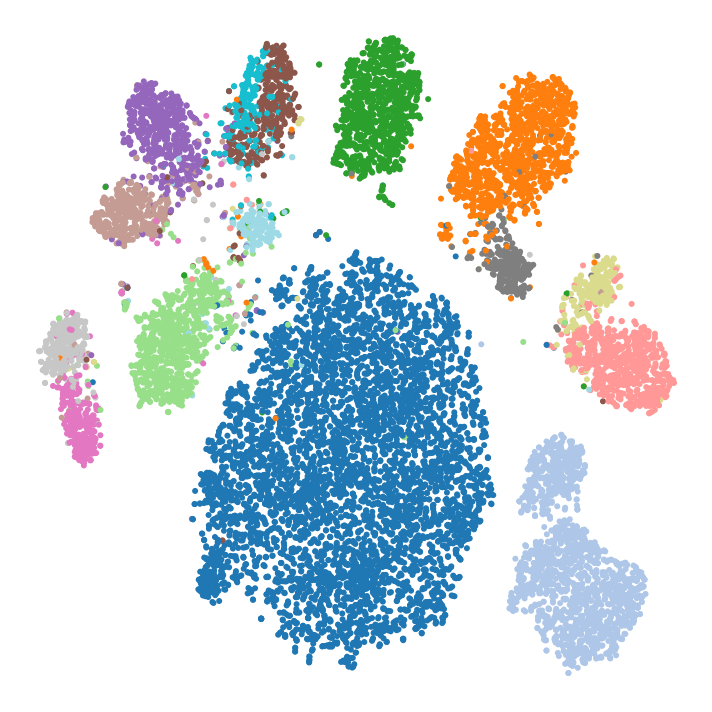

In [15]:
latent = helper.plot_tSNE(W.numpy(),
                          retina.cluster[indices], 
                         cmap=plt.get_cmap("tab20", 15))

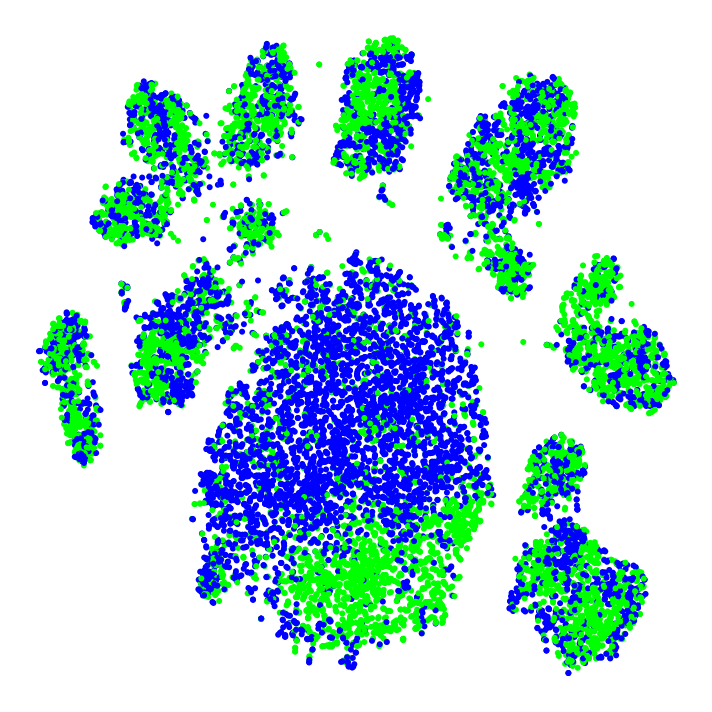

In [16]:
_ =  helper.plot_tSNE(latent, 
                      retina.batchID[indices],
                      cmap=plt.get_cmap("brg", 2), 
                      perform_tsne=False)